In [1]:
root_path = "C:/Users/wrksy/OneDrive/Desktop/second semester/7120CEM_Clickbait-Spoiling-Challenge/data"

In [2]:
root_path = root_path + "/"

In [3]:
! pip install transformers
! pip install evaluate
! pip install scikit-learn
! pip install -U pip
! pip install -U seaborn
! pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [24]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate
import json
import pandas as pd
import seaborn as sns
from nltk import ngrams
from collections import Counter
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator

from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook
import json
from itertools import chain

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Define file paths for training and validation datasets
train_file_path = root_path + 'train.jsonl'  # Path to the training JSONL file
val_file_path = root_path + 'validation.jsonl'  # Path to the validation JSONL file

# Define file paths for classification data
train_classification_data_svm_file_path = root_path + 'train_classification_data_svm.jsonl'  # Path to save SVM training data
undersampled_train_classification_data_svm_file_path = root_path + 'undersampled_train_classification_data_svm.jsonl'  # Path to save undersampled SVM training data
val_classification_data_svm_file_path = root_path + 'val_classification_data_svm.jsonl'  # Path to save SVM validation data

In [6]:
# Function to load and filter data from JSONL file
import json

def load_data(file_path):
    """
    Load data from a JSONL file and filter specific fields.

    Parameters:
    file_path (str): Path to the JSONL file.

    Returns:
    list: List of dictionaries containing filtered data.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
        filtered_sentences = [
            {
                _key: _value 
                for _key, _value in _sentence.items() 
                if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']
            } 
            for _sentence in sentences
        ]
    return filtered_sentences

# Load and preprocess data
train_data = load_data(train_file_path)  # Load training data
val_data = load_data(val_file_path)  # Load validation data

In [7]:
# Function to reformat spoiler positions based on observed heuristics
def reformat_spoiler_positions(data):
    """
    Reformat spoiler positions based on observed heuristics during data analysis.

    Parameters:
    data (list): List of dictionaries containing original data.

    Returns:
    tuple: Tuple containing reformatted data and list of indices to ignore.
    """
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):

        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('Ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]

            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:

                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):

                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1, None)]

                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]

                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)

            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({
            **_sentence,
            'allTargetParagraphs': all_target_paragraphs,
            'refactoredSpoilerPositions': refactored_spoiler_positions
        })
        
    return reformatted_data, ignore_idx


In [8]:
# Reformat data with proper spoiler positions using observed heuristics.
# The `reformat_spoiler_positions` function is applied to the training and validation data
# to adjust and correct spoiler positions based on heuristics observed during data analysis.
# The restructured data is stored in `train_data_reformatted` and `val_data_reformatted`.
train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

Ignoring idx: 546


In [9]:
# Remove data datapoints where the spoiler positions don't match the actual spoiler text
def remove_bad_matches_data(data):
    """
    Remove data points where the specified spoiler positions do not match the actual spoiler text.

    Args:
    - data (list): List of dictionaries, each containing information about a sentence.

    Returns:
    - clean_data (list): List of cleaned sentence dictionaries where the spoiler positions match the actual spoiler text.
    - exact_match_bad_annotations_ids (list): List of indices where exact matches were not found.
    - not_found_exact_matches (dict): Dictionary where keys are indices and values are lists of exact matches not found.

    """
    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matches = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matches:
                        not_found_exact_matches[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matches[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matches

In [10]:
# Clean data by removing datapoints where the spoiler positions do not match the actual spoiler text.
# The `remove_bad_matches_data` function is applied to the reformatted training and validation data
# (`train_data_reformatted` and `val_data_reformatted`) to eliminate instances where the specified spoiler
# positions do not accurately correspond to the actual spoiler text. The resulting cleaned data is stored
# in `clean_train_data` and `clean_val_data`, while `not_found_spoilers_train` and `not_found_spoilers_val`
# contain information about exact matches that were not found during the cleaning process.

clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)


In [11]:
# Flatten nested data.
# change_multi true will relabel the multi-spoiler data as either phrase or passage depending on
# the length of the spoiler.

def flatten_data(data, change_multi=True):
    """
    Flatten nested data from a structured format into a flat format suitable for analysis.
    
    Parameters:
    - data: List of dictionaries representing nested data.
    - change_multi: Boolean flag to determine how multi-spoiler data should be relabeled.
                    If True, multi-spoiler data is relabeled as either 'phrase' or 'passage'
                    based on the length of the spoiler text segments. If False, multi-spoiler
                    data retains its original labels.

    Returns:
    - flattened_data: List of dictionaries containing flattened data.
    """

    flattened_data = []
    for _sentence in data:

        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

In [12]:
# Flatten nested data after cleaning and normalization.
# Here, the `flatten_data` function is applied to cleaned training and validation data
# to convert nested structures into a flat format suitable for further processing and analysis.
flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)


In [25]:
# This function takes a text string and an integer n, splits the text into tokens, 
# and returns a list of n-grams (tuples of n consecutive tokens).
def generate_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

# Function to prepare n-grams data from flattened data
# This function iterates through the flattened data, combines the post text and target paragraph,
# generates n-grams, and appends them along with the corresponding uuid, target paragraph ID, and spoiler type to a list.
def prepare_ngrams_data(flattened_data, n=2):
    ngrams_data = []
    for _x in flattened_data:
        text = _x['postText'] + ' ' + _x['targetParagraph']
        ngrams = generate_ngrams(text, n)
        ngrams_data.append({
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'ngrams': ngrams,
            'spoilerType': _x['spoilerType']
        })
    return ngrams_data

# Generate bi-grams and tri-grams for training and validation data
# Using the prepare_ngrams_data function to create lists of bi-grams and tri-grams for both training and validation datasets.
bigrams_train_data = prepare_ngrams_data(flattened_train_data, n=2)
trigrams_train_data = prepare_ngrams_data(flattened_train_data, n=3)
bigrams_val_data = prepare_ngrams_data(flattened_val_data, n=2)
trigrams_val_data = prepare_ngrams_data(flattened_val_data, n=3)

# Displaying the first few entries of the bi-grams and tri-grams
# Printing out examples of the generated bi-grams and tri-grams for both training and validation data to verify the output.
print("Bigrams Training Data Example: ", bigrams_train_data[:2])
print("-" * 50)
print("Trigrams Training Data Example: ", trigrams_train_data[:2])
print("-" * 50)
print("Bigrams Validation Data Example: ", bigrams_val_data[:2])
print("-" * 50)
print("Trigrams Validation Data Example: ", trigrams_val_data[:2])



Bigrams Training Data Example:  [{'uuid': '0af11f6b-c889-4520-9372-66ba25cb7657', 'targetParagraphId': 0, 'ngrams': [('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'Better'), ('Better', 'Idea'), ('Idea', 'Wes'), ('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'A'), ('A', 'Better'), ('Better', 'Idea')], 'spoilerType': None}, {'uuid': '0af11f6b-c889-4520-9372-66ba25cb7657', 'targetParagraphId': 1, 'ngrams': [('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'Better'), ('Better', 'Idea'), ('Idea', 'It’ll'), ('It’ll', 'be'), ('be', 'just

<Axes: xlabel='Data', ylabel='Count'>

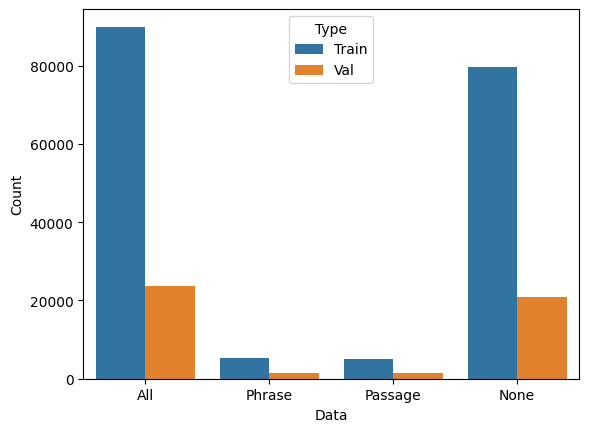

In [16]:
# flattened data distribution
distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data":['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})
sns.barplot(distribution_df, x="Data" , y="Count", hue="Type")


In [17]:
# Prepare classification data from flattened data
# This function takes in `flattened_data`, extracts relevant information such as UUID,
# target paragraph ID, concatenated text from 'postText' and 'targetParagraph', and
# assigns labels based on 'spoilerType' ('phrase' as 1, 'passage' as 2, and None as 0).
# It optionally undersamples data with a specified ratio (`undersample_ratio`) to balance
# the distribution of 'None' labels relative to 'phrase' and 'passage'.
# The function returns `undersampled_data`, which includes a balanced subset of the data
# for classification purposes.

def prepare_classification_data(flattened_data, undersample_ratio=1.0):
    clasification_data = []
    undersampled_data = []
    
    for _x in flattened_data:
        _label = 0        
        if _x['spoilerType'] == 'phrase':
            _label = 1
        elif _x['spoilerType'] == 'passage':
            _label = 2

        _data = {
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'text': _x['postText'] + ' ' + _x['targetParagraph'],
            'labels': _label,
            # **_x
          }
        clasification_data.append(_data)
    
    none_data = [_data for _data in clasification_data if _data['labels'] == 0]
    len_undersampled = int(len(none_data) * undersample_ratio)
    for _data in np.random.choice(none_data, size=len_undersampled, replace=False):
        undersampled_data.append(_data)
    for _x in clasification_data:
        if _x['labels'] in [1, 2]:
            undersampled_data.append(_x)
    
    return undersampled_data

In [18]:
# Create prepared data for further analysis and training
# This section prepares classification data for training and validation by calling the
# `prepare_classification_data` function on `flattened_train_data` and `flattened_val_data`.
# It generates three datasets:
# - `classification_train_data`: Full training data prepared for classification tasks.
# - `undersampled_classification_train_data`: Training data undersampled to balance the
#   'None' labels relative to 'phrase' and 'passage' labels, using a specified `undersample_ratio`.
# - `classification_val_data`: Validation data prepared for classification tasks.

classification_train_data = prepare_classification_data(flattened_data=flattened_train_data)
undersampled_classification_train_data = prepare_classification_data(flattened_data=flattened_train_data, undersample_ratio=0.3)
classification_val_data = prepare_classification_data(flattened_data=flattened_val_data)


In [19]:
# Reformat the data as DataFrames
# This section converts the undersampled_classification_train_data and classification_val_data
# into pandas DataFrames, where each DataFrame has columns 'text' and 'labels'.
# - df_classification_train: DataFrame for undersampled training data with 'text' and 'labels' columns.
# - df_classification_val: DataFrame for validation data with 'text' and 'labels' columns.

df_classification_train = pd.DataFrame(columns=['text', 'labels'], data=undersampled_classification_train_data)
df_classification_val = pd.DataFrame(columns=['text', 'labels'], data=classification_val_data)

In [20]:
# Train classifiers and evaluate their performance

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Split data into training and validation sets
x_train, x_test = df_classification_train['text'], df_classification_val['text']
y_train, y_test = df_classification_train['labels'], df_classification_val['labels']

# Encode labels using LabelEncoder
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Encode the preprocessed texts as TF-IDF vectors
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3, smooth_idf=True)
x_train_vector = vectorizer.fit_transform(x_train)
x_test_vector = vectorizer.transform(x_test)

# Train SVM model
clf_svm = SVC(kernel="linear", max_iter=500, C=1.0, gamma='scale')
clf_svm.fit(x_train_vector, y_train_encoded)

# Predictions for SVM
y_pred_svm = clf_svm.predict(x_test_vector)

# Train Logistic Regression model
clf_lr = LogisticRegression(max_iter=500, solver='lbfgs')
clf_lr.fit(x_train_vector, y_train_encoded)

# Predictions for Logistic Regression
y_pred_lr = clf_lr.predict(x_test_vector)

# Train Naive Bayes model
clf_nb = MultinomialNB()
clf_nb.fit(x_train_vector, y_train_encoded)

# Predictions for Naive Bayes
y_pred_nb = clf_nb.predict(x_test_vector)

# Evaluate classifiers
print("SVM Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_svm))
print(classification_report(y_test_encoded, y_pred_svm))

print("Logistic Regression Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_lr))
print(classification_report(y_test_encoded, y_pred_lr))

print("Naive Bayes Classification Accuracy:", accuracy_score(y_test_encoded, y_pred_nb))
print(classification_report(y_test_encoded, y_pred_nb))

SVM Classification Accuracy: 0.759058427910887
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     20972
           1       0.08      0.04      0.05      1362
           2       0.08      0.16      0.10      1456

    accuracy                           0.76     23790
   macro avg       0.35      0.35      0.34     23790
weighted avg       0.79      0.76      0.77     23790

Logistic Regression Classification Accuracy: 0.8789827658680117
              precision    recall  f1-score   support

           0       0.88      0.99      0.94     20972
           1       0.15      0.01      0.02      1362
           2       0.41      0.04      0.07      1456

    accuracy                           0.88     23790
   macro avg       0.48      0.35      0.34     23790
weighted avg       0.81      0.88      0.83     23790

Naive Bayes Classification Accuracy: 0.8821773854560739
              precision    recall  f1-score   support

           0    

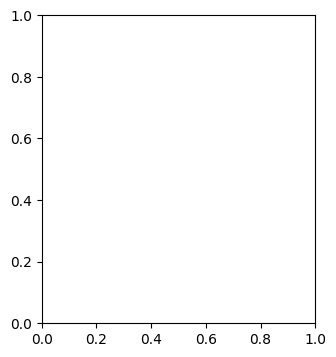

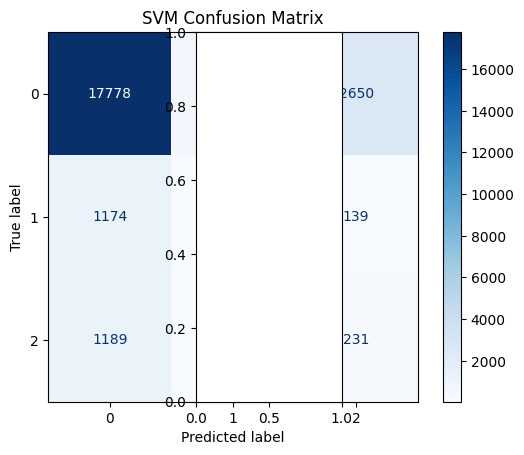

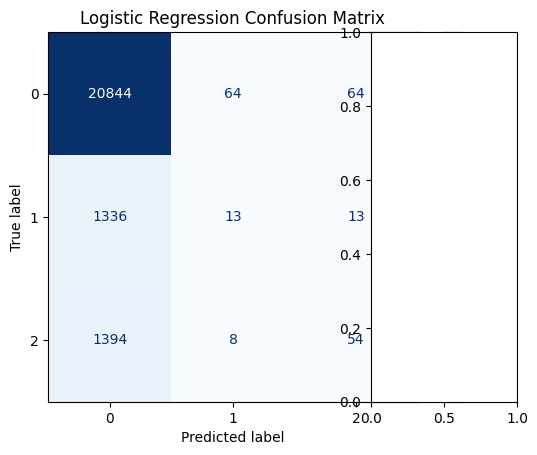

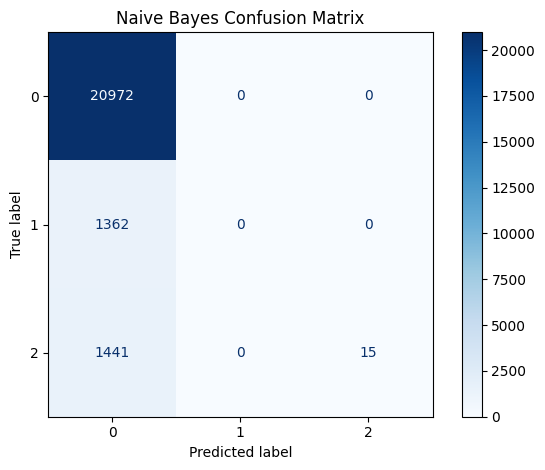

In [21]:
# Confusion Matrix Visualization

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Generate confusion matrices
cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
cm_lr = confusion_matrix(y_test_encoded, y_pred_lr)
cm_nb = confusion_matrix(y_test_encoded, y_pred_nb)

# Plot SVM confusion matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=label_encoder.classes_)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')

# Plot Logistic Regression confusion matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=label_encoder.classes_)
plt.subplot(1, 3, 2)
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')

# Plot Naive Bayes confusion matrix
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=label_encoder.classes_)
plt.subplot(1, 3, 3)
disp_nb.plot(cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')

plt.tight_layout()
plt.show()